In [29]:
from IPython.display import display
import IPython
import pandas as pd
from pandas import Series
import numpy as np
from random import randrange

from matplotlib import pyplot
import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose

# np.float_ = np.float64
# from prophet import Prophet

import math
from typing import Any, List, Dict, AnyStr, Optional
from pathlib import Path
from glob import glob

from utils.dataset import MarketData
from utils.windowgenerator import WindowGenerator, compile_and_fit
import tensorflow as tf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import talib

In [3]:
import pandas as pd
import talib

def calculate_rolling_mean(df, column_name, window):
    """
    Calculate the rolling mean (SMA) for a specific column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time series data.
    column_name (str): The column name on which to calculate the rolling mean.
    window (int): The window size for calculating the rolling mean.
    
    Returns:
    pd.Series: A Pandas Series containing the rolling mean values.
    """
    return df[column_name].rolling(window=window).mean()

def calculate_ema(df, column_name, window):
    """
    Calculate the Exponential Moving Average (EMA) for a specific column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time series data.
    column_name (str): The column name on which to calculate the EMA.
    window (int): The window size for calculating the EMA.
    
    Returns:
    pd.Series: A Pandas Series containing the EMA values.
    """
    return talib.EMA(df[column_name], timeperiod=window)

# Example usage:
# Assume df is your DataFrame containing time series data with a column named 'price'

# Calculate a 20-day rolling mean for the 'price' column

## Dataset

### Loading Dataset

In [46]:
cot_df, auction_df, eua_df, ta_df, fundamentals_df = MarketData.latest(Path('data'))
cot_df = cot_df.set_index('Date').resample('W', origin='end').mean().reset_index()
auction_df = auction_df.set_index('Date').resample('W').mean().reset_index()


In [47]:
cot_df.head()

,Date,net_speculators,spec_long_%,spec_short_%,Long/Short
0,2018-01-21,55281.97,7.42,0.08,92.750000
1,2018-01-28,55412.89,7.37,0.05,147.400000
2,2018-02-04,56881.56,5.97,0.11,54.272727
3,2018-02-11,43466.55,6.11,0.11,55.545455
4,2018-02-18,44053.00,6.10,0.13,46.923077


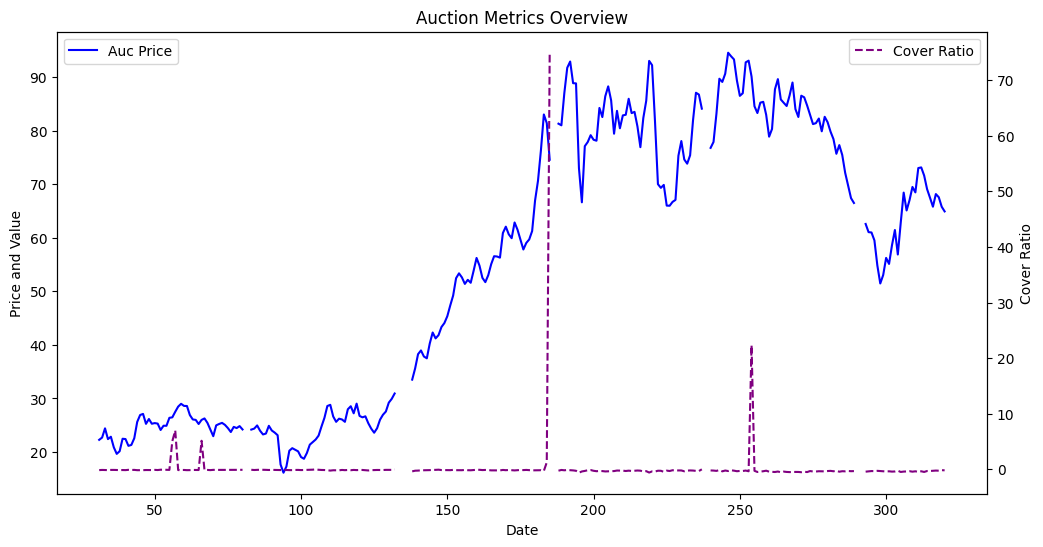

In [48]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 'Auc Price', 'Median Price', 'Spot Value' on primary y-axis
ax1.plot(auction_df[auction_df.set_index('Date').index.year > 2018]['Auc Price'], label='Auc Price', color='blue')
# ax1.plot(auction_df[auction_df.index.year > 2018]['Median Price'], label='Median Price', color='green')
# ax1.plot(auction_df[auction_df.index.year > 2018]['Spot Value'], label='Spot Value', color='red')

# Set labels and title
ax1.set_xlabel('Date')  # Assuming the index of auction_df is the date
ax1.set_ylabel('Price and Value')
ax1.set_title('Auction Metrics Overview')
ax1.legend(loc='upper left')

# Create a second y-axis for 'Cover Ratio'
ax2 = ax1.twinx()
ax2.plot(auction_df[auction_df.set_index('Date').index.year > 2018]['Median Spot Diff'], label='Cover Ratio', color='purple', linestyle='--')
ax2.set_ylabel('Cover Ratio')

# Adding legend for the second axis
ax2.legend(loc='upper right')

# Show plot
plt.show()

### Merging Dataset

In [49]:
def merge_auc_cot(auction_df, cot_df):
    merged_df = pd.merge_asof(auction_df, cot_df, on='Date', direction='backward')
    merged_df.ffill(inplace=True)
    merged_df.bfill(inplace=True)
    merged_df.drop(["Spot Value", "Median Price"], axis=1, inplace=True)
    merged_df.loc[:, 'Pct_Change_Auc_Price'] = merged_df['Auc Price'].pct_change() * 100
    merged_df = merged_df.dropna(subset=['Pct_Change_Auc_Price'])

    merged_df['7 MA Premium/discount-settle'] = calculate_rolling_mean(merged_df, 'Premium/discount-settle', 7)
    merged_df['20 MA Premium/discount-settle'] = calculate_rolling_mean(merged_df, 'Premium/discount-settle', 20)
    merged_df['7 EMA Premium/discount-settle'] = calculate_ema(merged_df, 'Premium/discount-settle', 7)
    merged_df['20 EMA Premium/discount-settle'] = calculate_ema(merged_df, 'Premium/discount-settle', 20)

    merged_df['delta_auc'] = merged_df['Auc Price'].diff(2)
    merged_df['delta_auc_4'] = merged_df['Auc Price'].diff(4)
    merged_df['auc_T-2'] = merged_df['Auc Price'].shift(2)
    merged_df['auc_T-4'] = merged_df['Auc Price'].shift(4)

    merged_df['delta_ls'] = merged_df['Long/Short'].diff(2)
    merged_df['delta_ls_4'] = merged_df['Long/Short'].diff(4)
    merged_df['ls_T-2'] = merged_df['Auc Price'].shift(2)
    merged_df['ls_T-4'] = merged_df['Auc Price'].shift(4)


    merged_df.dropna(inplace=True)

    return merged_df

merged_df = merge_auc_cot(auction_df, cot_df)

In [50]:
def merge_auc_cot(auction_df, cot_df):
    # Merge DataFrames
    merged_df = pd.merge_asof(auction_df, cot_df, on='Date', direction='backward')
    merged_df.ffill(inplace=True)
    merged_df.bfill(inplace=True)
    
    # Drop unnecessary columns
    merged_df.drop(["Spot Value", "Median Price"], axis=1, inplace=True)
    
    # Calculate percentage change in Auc Price
    merged_df.loc[:, 'Pct_Change_Auc_Price'] = merged_df['Auc Price'].pct_change() * 100
    merged_df = merged_df.dropna(subset=['Pct_Change_Auc_Price'])

    ### Rolling Means and Exponential Moving Averages
    merged_df['7 MA Premium/discount-settle'] = ta.SMA(merged_df['Premium/discount-settle'], timeperiod=7)
    merged_df['20 MA Premium/discount-settle'] = ta.SMA(merged_df['Premium/discount-settle'], timeperiod=20)
    merged_df['7 EMA Premium/discount-settle'] = ta.EMA(merged_df['Premium/discount-settle'], timeperiod=7)
    merged_df['20 EMA Premium/discount-settle'] = ta.EMA(merged_df['Premium/discount-settle'], timeperiod=20)
    
    merged_df['7 MA net_speculators'] = ta.SMA(merged_df['net_speculators'], timeperiod=7)
    merged_df['20 MA net_speculators'] = ta.SMA(merged_df['net_speculators'], timeperiod=20)
    merged_df['7 EMA net_speculators'] = ta.EMA(merged_df['net_speculators'], timeperiod=7)
    merged_df['20 EMA net_speculators'] = ta.EMA(merged_df['net_speculators'], timeperiod=20)
    
    merged_df['7 MA spec_long_%'] = ta.SMA(merged_df['spec_long_%'], timeperiod=7)
    merged_df['20 MA spec_long_%'] = ta.SMA(merged_df['spec_long_%'], timeperiod=20)
    
    merged_df['7 EMA spec_long_%'] = ta.EMA(merged_df['spec_long_%'], timeperiod=7)
    merged_df['20 EMA spec_long_%'] = ta.EMA(merged_df['spec_long_%'], timeperiod=20)

    ### Lagged Features
    merged_df['delta_auc'] = merged_df['Auc Price'].diff(2)
    merged_df['delta_auc_4'] = merged_df['Auc Price'].diff(4)
    merged_df['auc_T-2'] = merged_df['Auc Price'].shift(2)
    merged_df['auc_T-4'] = merged_df['Auc Price'].shift(4)

    merged_df['delta_ls'] = merged_df['Long/Short'].diff(2)
    merged_df['delta_ls_4'] = merged_df['Long/Short'].diff(4)
    merged_df['ls_T-2'] = merged_df['Long/Short'].shift(2)
    merged_df['ls_T-4'] = merged_df['Long/Short'].shift(4)
    
    merged_df['delta_net_spec_2'] = merged_df['net_speculators'].diff(2)
    merged_df['delta_net_spec_4'] = merged_df['net_speculators'].diff(4)
    merged_df['net_spec_T-2'] = merged_df['net_speculators'].shift(2)
    merged_df['net_spec_T-4'] = merged_df['net_speculators'].shift(4)

    merged_df['delta_spec_long_2'] = merged_df['spec_long_%'].diff(2)
    merged_df['delta_spec_long_4'] = merged_df['spec_long_%'].diff(4)
    merged_df['spec_long_T-2'] = merged_df['spec_long_%'].shift(2)
    merged_df['spec_long_T-4'] = merged_df['spec_long_%'].shift(4)

    merged_df['delta_spec_short_2'] = merged_df['spec_short_%'].diff(2)
    merged_df['delta_spec_short_4'] = merged_df['spec_short_%'].diff(4)
    merged_df['spec_short_T-2'] = merged_df['spec_short_%'].shift(2)
    merged_df['spec_short_T-4'] = merged_df['spec_short_%'].shift(4)

    ### Momentum and Volatility Features
    merged_df['RSI_Auc_Price'] = ta.RSI(merged_df['Auc Price'], timeperiod=14)
    merged_df['Momentum_Auc_Price'] = ta.MOM(merged_df['Auc Price'], timeperiod=10)
    merged_df['Volatility_Auc_Price'] = ta.STDDEV(merged_df['Auc Price'], timeperiod=5, nbdev=1)
    
    ### Additional Indicators
    merged_df['Upper_Band'], merged_df['Middle_Band'], merged_df['Lower_Band'] = ta.BBANDS(merged_df['Auc Price'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    merged_df['MACD_Auc_Price'], _, _ = ta.MACD(merged_df['Auc Price'], fastperiod=12, slowperiod=26, signalperiod=9)
    merged_df['ATR'] = ta.ATR(merged_df['Auc Price'], merged_df['Auc Price'], merged_df['Auc Price'], timeperiod=14)

    merged_df.dropna(inplace=True)

    return merged_df



In [51]:
print(f"COT Cols: {cot_df.columns}")
print(f"AUC Cols: {auction_df.columns}")

COT Cols: Index(['Date', 'net_speculators', 'spec_long_%', 'spec_short_%', 'Long/Short'], dtype='object')
AUC Cols: Index(['Date', 'Auc Price', 'Median Price', 'Cover Ratio', 'Spot Value',
       'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle'],
      dtype='object')


In [52]:
# Example usage
merged_df = merge_auc_cot(auction_df, cot_df)

In [53]:
merged_df.head()

,Date,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short,...,spec_short_T-2,spec_short_T-4,RSI_Auc_Price,Momentum_Auc_Price,Volatility_Auc_Price,Upper_Band,Middle_Band,Lower_Band,MACD_Auc_Price,ATR
34,2019-02-03,22.4060,2.3440,-0.060,-0.1320,-0.002713,47168.55,7.08,2.23,3.174888,...,2.12,1.90,60.041437,2.913500,0.791352,24.850267,20.871950,16.893633,1.530430,0.911242
35,2019-02-10,22.8475,2.1625,-0.010,-0.1000,-0.000426,43985.39,6.82,2.29,2.978166,...,2.16,2.19,61.477164,3.237500,0.771178,25.032318,20.961825,16.891332,1.479787,0.877689
36,2019-02-17,20.8740,2.0060,-0.020,-0.0980,-0.000962,40686.83,6.56,2.36,2.779661,...,2.23,2.12,52.411855,0.966500,1.128168,25.027593,20.956925,16.886257,1.265816,0.955961
37,2019-02-24,19.6500,2.7175,-0.045,-0.1175,-0.002347,35458.73,6.20,2.54,2.440945,...,2.29,2.16,47.712582,-1.156667,1.642581,24.993177,20.883925,16.774673,0.986109,0.975107
38,2019-03-03,20.1480,2.2380,-0.004,-0.1280,-0.000140,35967.52,6.16,2.38,2.588235,...,2.36,2.23,49.689078,-3.252000,1.247643,24.984153,20.865025,16.745897,0.795453,0.941028


In [54]:
print(merged_df.shape)
merged_df.head()

(287, 51)


,Date,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short,...,spec_short_T-2,spec_short_T-4,RSI_Auc_Price,Momentum_Auc_Price,Volatility_Auc_Price,Upper_Band,Middle_Band,Lower_Band,MACD_Auc_Price,ATR
34,2019-02-03,22.4060,2.3440,-0.060,-0.1320,-0.002713,47168.55,7.08,2.23,3.174888,...,2.12,1.90,60.041437,2.913500,0.791352,24.850267,20.871950,16.893633,1.530430,0.911242
35,2019-02-10,22.8475,2.1625,-0.010,-0.1000,-0.000426,43985.39,6.82,2.29,2.978166,...,2.16,2.19,61.477164,3.237500,0.771178,25.032318,20.961825,16.891332,1.479787,0.877689
36,2019-02-17,20.8740,2.0060,-0.020,-0.0980,-0.000962,40686.83,6.56,2.36,2.779661,...,2.23,2.12,52.411855,0.966500,1.128168,25.027593,20.956925,16.886257,1.265816,0.955961
37,2019-02-24,19.6500,2.7175,-0.045,-0.1175,-0.002347,35458.73,6.20,2.54,2.440945,...,2.29,2.16,47.712582,-1.156667,1.642581,24.993177,20.883925,16.774673,0.986109,0.975107
38,2019-03-03,20.1480,2.2380,-0.004,-0.1280,-0.000140,35967.52,6.16,2.38,2.588235,...,2.36,2.23,49.689078,-3.252000,1.247643,24.984153,20.865025,16.745897,0.795453,0.941028


### Train & Test Data

In [55]:
def train_test_data(merged_df, features = []):
    if len(features) == 0:
        FEATURES = ['Auc Price', 'Cover Ratio', 'Auction Spot Diff',
       'Median Spot Diff', 'Premium/discount-settle', 'net_speculators',
       'spec_long_%', 'spec_short_%', 'Long/Short', 'Pct_Change_Auc_Price',
       'delta_auc', 'delta_auc_4', 'auc_T-2', 'auc_T-4', 'delta_ls',
       'delta_ls_4', 'ls_T-2', 'ls_T-4']
        
    else: 
        FEATURES = [feature for feature in features if feature != 'Date']
    train_df = merged_df[merged_df['Date'] <
                        "2024-02-01"].copy().set_index('Date')[FEATURES].copy()
    
    val_df = merged_df[(merged_df['Date'] >= "2024-02-01") & (merged_df['Date'] < "2024-07-01")].copy().set_index('Date')[FEATURES].copy()
    
    test_df = merged_df[merged_df['Date'] >= "2024-07-01"].copy().set_index('Date')[FEATURES].copy()

    return train_df, test_df, val_df

train_df, test_df, val_df = train_test_data(merged_df)


#### Dataset Normalization

In [56]:
def normalize(train_df, test_df, val_df):
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

    return train_df, test_df, val_df

# Normalize
train_df, test_df, val_df = normalize(train_df, test_df, val_df)
num_features = train_df.shape[1]    

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20]
Label column name(s): None

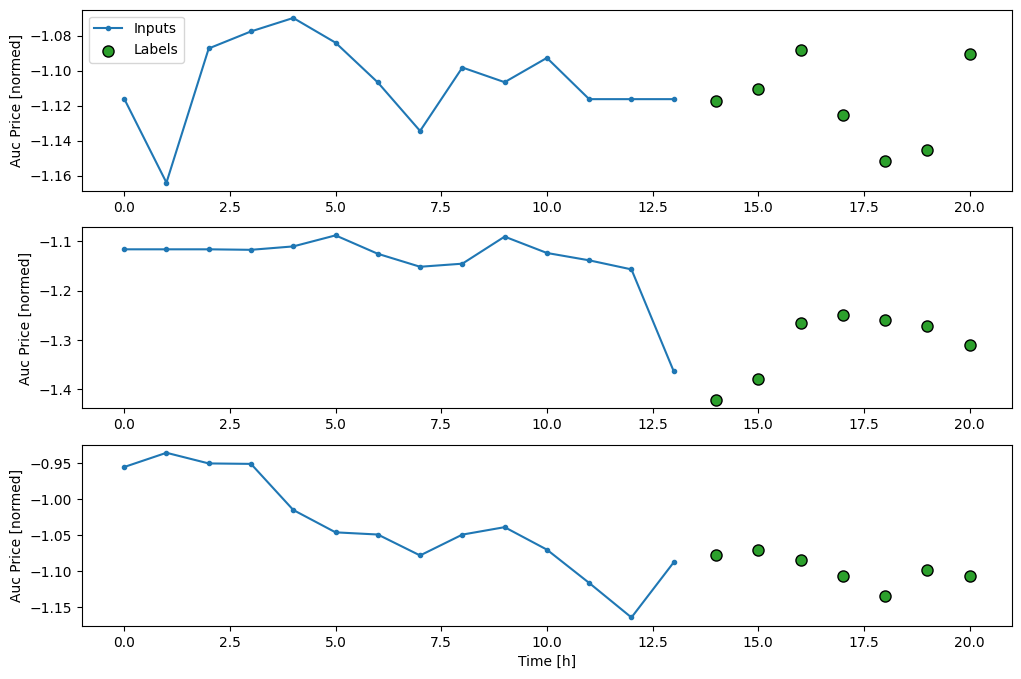

In [62]:
OUT_STEPS = 7

multi_window = WindowGenerator(input_width=14,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [63]:
multi_window.plot_test()

StopIteration: 

In [55]:
merged_df['Auc Price'] = merged_df['Auc Price'].round(2)

In [56]:
merged_df

,Date,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short,Pct_Change_Auc_Price,delta_auc,delta_auc_4,auc_T-2,auc_T-4,delta_ls,delta_ls_4,ls_T-2,ls_T-4
5,2018-07-15,16.00,3.040000,-0.0750,-0.1025,-0.004669,51059.21,5.50,0.69,7.971014,4.744764,1.015000,0.795000,14.9900,15.2100,-0.305909,-7.195652,14.9900,15.2100
6,2018-07-22,16.31,3.222000,-0.0460,-0.0800,-0.002815,54874.03,5.74,0.60,9.566667,1.893158,1.028000,1.852000,15.2800,14.4560,0.905376,-0.760256,15.2800,14.4560
7,2018-07-29,17.14,3.042500,-0.0425,-0.1075,-0.002470,54438.12,5.57,0.55,10.127273,5.086461,1.132500,2.147500,16.0050,14.9900,2.156258,1.850350,16.0050,14.9900
8,2018-08-05,17.27,4.386000,0.0160,-0.0640,0.000931,57345.88,5.91,0.63,9.380952,0.773158,0.962000,1.990000,16.3080,15.2800,-0.185714,0.719662,16.3080,15.2800
9,2018-08-12,17.57,4.925000,0.0425,-0.0500,0.002429,59152.83,6.02,0.63,9.555556,1.737116,0.432500,1.565000,17.1375,16.0050,-0.571717,1.584541,17.1375,16.0050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2024-06-30,65.80,1.537500,-0.1200,-0.2550,-0.001822,-21215.03,5.13,8.23,0.623329,-2.482585,-3.282500,-7.335000,69.0775,73.1300,-0.115323,-0.229456,69.0775,73.1300
317,2024-07-07,68.15,1.498000,-0.2080,-0.2160,-0.003043,-17487.03,5.22,7.67,0.680574,3.585379,0.684000,-3.456000,67.4700,71.6100,0.037613,-0.135891,67.4700,71.6100
318,2024-07-14,67.56,1.654000,-0.2200,-0.2400,-0.003254,-18113.99,5.00,7.48,0.668449,-0.868621,1.767000,-1.515500,65.7950,69.0775,0.045120,-0.070203,65.7950,69.0775
319,2024-07-21,65.79,1.744000,0.0700,-0.1440,0.001050,-23378.80,5.18,8.33,0.621849,-2.625736,-2.366000,-1.682000,68.1540,67.4700,-0.058725,-0.021112,68.1540,67.4700


In [58]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, test_df=test_df, val_df=val_df,
    label_columns=['Auc Price'])


single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Auc Price']

In [59]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 18)
Output shape: (32, 1, 1)


In [60]:
val_performance = {}
performance = {}

In [61]:


MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6273 - mean_absolute_error: 2.2228 - val_loss: 11.3412 - val_mean_absolute_error: 3.2369
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1436 - mean_absolute_error: 2.0942 - val_loss: 10.9276 - val_mean_absolute_error: 3.1735
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4465 - mean_absolute_error: 1.9898 - val_loss: 10.5454 - val_mean_absolute_error: 3.1128
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7947 - mean_absolute_error: 2.0629 - val_loss: 10.1926 - val_mean_absolute_error: 3.0552
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6955 - mean_absolute_error: 2.0300 - val_loss: 9.8583 - val_mean_absolute_error: 2.9996
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0764 - mean_absolute_error: 1.9390 - val_loss: 9.5290 - val_mean_absolute_error: 2.9433
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8631 - mean_absolute_error: 1.8625 - val_loss: 9.2315 - val_me

In [73]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    train_df=train_df, test_df=test_df, val_df=val_df,
    label_width=1,
    shift=1,
    label_columns=['Auc Price'])

conv_window

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

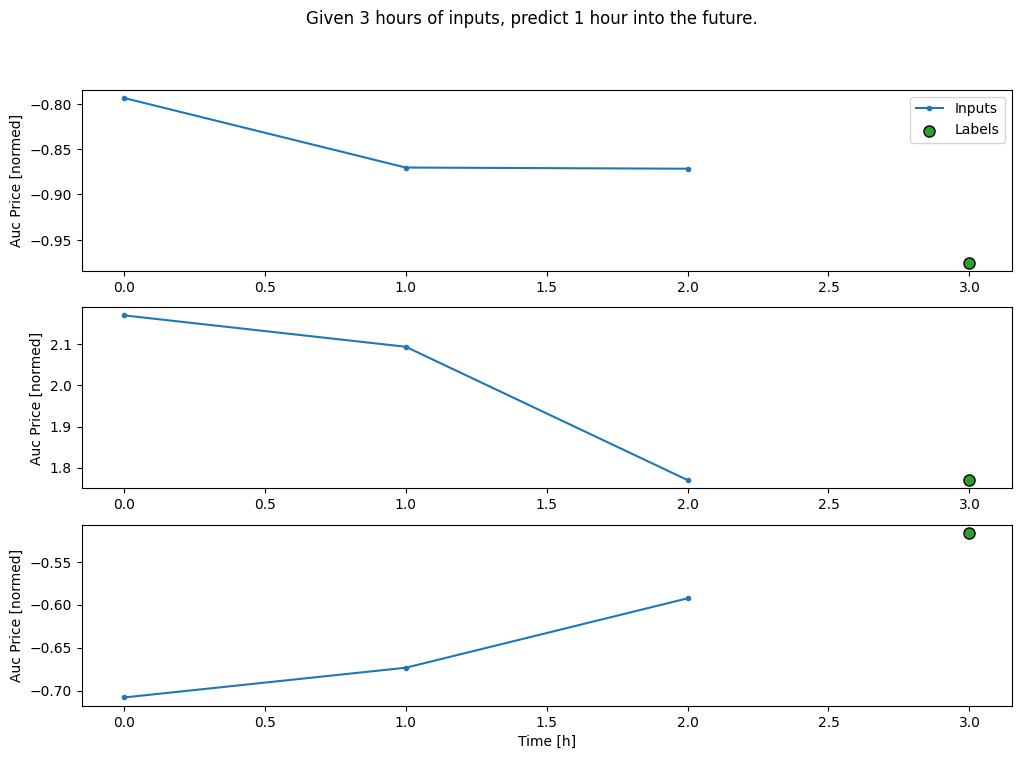

In [74]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

In [75]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [111]:
auction_df

,Auc Price,Median Price,Cover Ratio,Spot Value,Auction Spot Diff,Median Spot Diff,Premium/discount-settle
Date,,,,,,,
2018-06-10,15.850000,15.806000,2.132000,15.884000,-0.0340,-0.078,NaN
2018-06-17,15.210000,15.177500,1.902500,15.267500,-0.0575,-0.090,-0.003876
2018-06-24,14.456000,14.352000,2.608000,14.428000,0.0280,-0.076,0.001912
2018-07-01,14.990000,14.947500,2.582500,15.022500,-0.0325,-0.075,-0.002153
2018-07-08,15.280000,15.166000,3.570000,15.222000,0.0580,-0.056,0.003868
...,...,...,...,...,...,...,...
2024-06-30,65.795000,65.660000,1.537500,65.915000,-0.1200,-0.255,-0.001822
2024-07-07,68.154000,68.146000,1.498000,68.362000,-0.2080,-0.216,-0.003043
2024-07-14,67.562000,67.594000,1.654000,67.834000,-0.2200,-0.240,-0.003254


auction_df

In [76]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1303 - mean_absolute_error: 0.2741


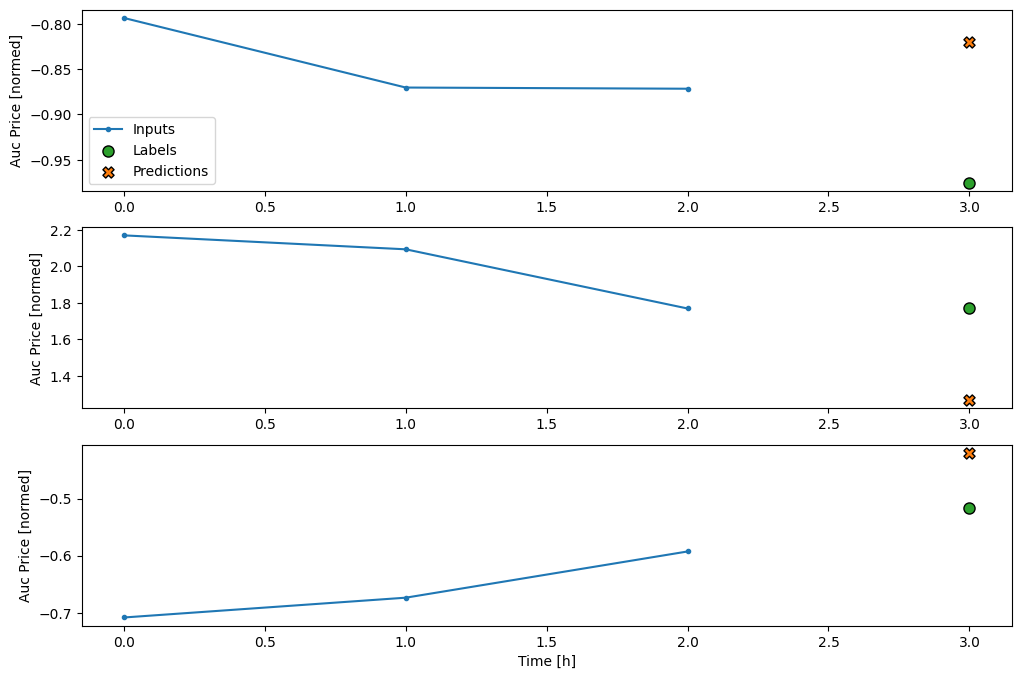

In [78]:
conv_window.plot(multi_step_dense)

In [81]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 18)
Output shape: (32, 1, 1)


In [82]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0782 - mean_absolute_error: 0.2413


In [83]:
LABEL_WIDTH = 3
CONV_WIDTH = 3
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

In [84]:
INPUT_WIDTH

5

In [86]:
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    train_df=train_df, test_df=test_df, val_df=val_df,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Auc Price'])
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 5, 18)
Labels shape: (32, 3, 1)
Output shape: (32, 3, 1)


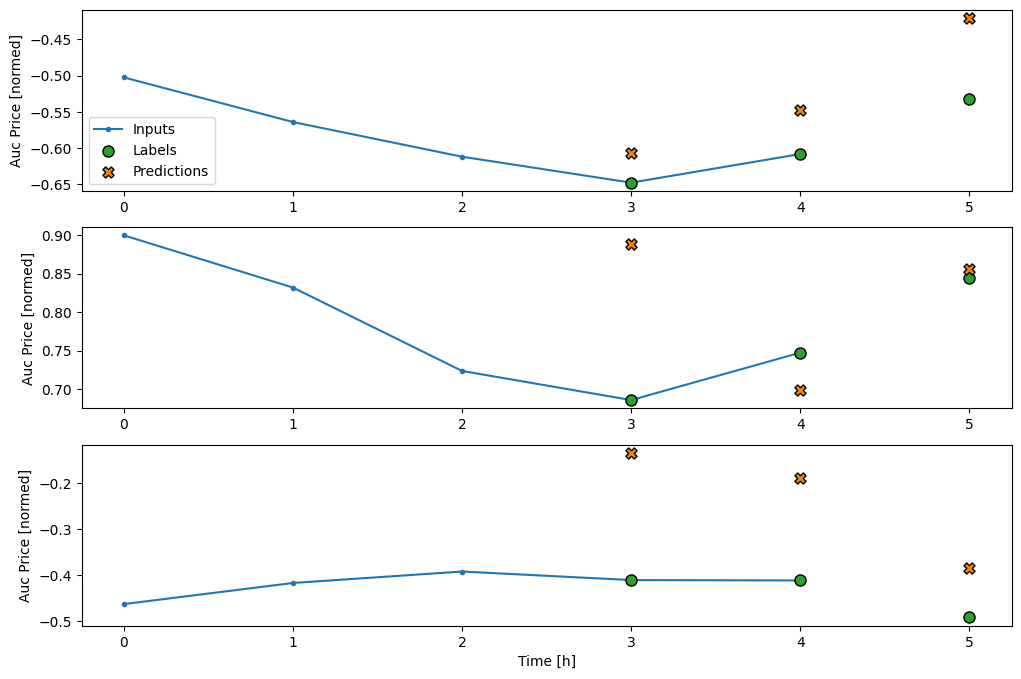

In [87]:
wide_conv_window.plot(conv_model)

## Modeling

### MultiStep Last Baseline

In [39]:
merged_df.head().to_csv(index=False)

'Date,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short,Pct_Change_Auc_Price,delta_auc,T-2,delta_auc_4,auc_T-2,auc_T-4,delta_ls,delta_ls_4,ls_T-2,ls_T-4\n2018-06-09,15.78,1.77,-0.09,-0.06999999999999851,0.0006373486297004462,50668.63,5.4,0.39,13.846153846153847,0.0,-0.3600000000000012,16.35,-0.5700000000000021,16.14,16.35,0.0,0.0,16.14,16.35\n2018-06-10,15.78,1.77,-0.09,-0.06999999999999851,0.0006373486297004462,50838.47,5.4,0.39,13.846153846153847,0.0,0.0,15.7,0.08000000000000007,15.78,15.7,0.0,0.0,15.78,15.7\n2018-06-11,15.7,2.03,0.01,-0.09999999999999964,0.0006373486297004462,50838.47,5.4,0.39,13.846153846153847,-0.5069708491761693,-0.08000000000000007,16.14,-0.4400000000000013,15.78,16.14,0.0,0.0,15.78,16.14\n2018-06-12,15.08,1.63,-0.12,-0.06999999999999851,-0.007894736842105263,50838.47,5.4,0.39,13.846153846153847,-3.9490445859872603,-0.6999999999999993,15.78,-0.6999999999999993,15.78,15.78,0.0,0.0,

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 0.7373 - mean_absolute_error: 0.3693


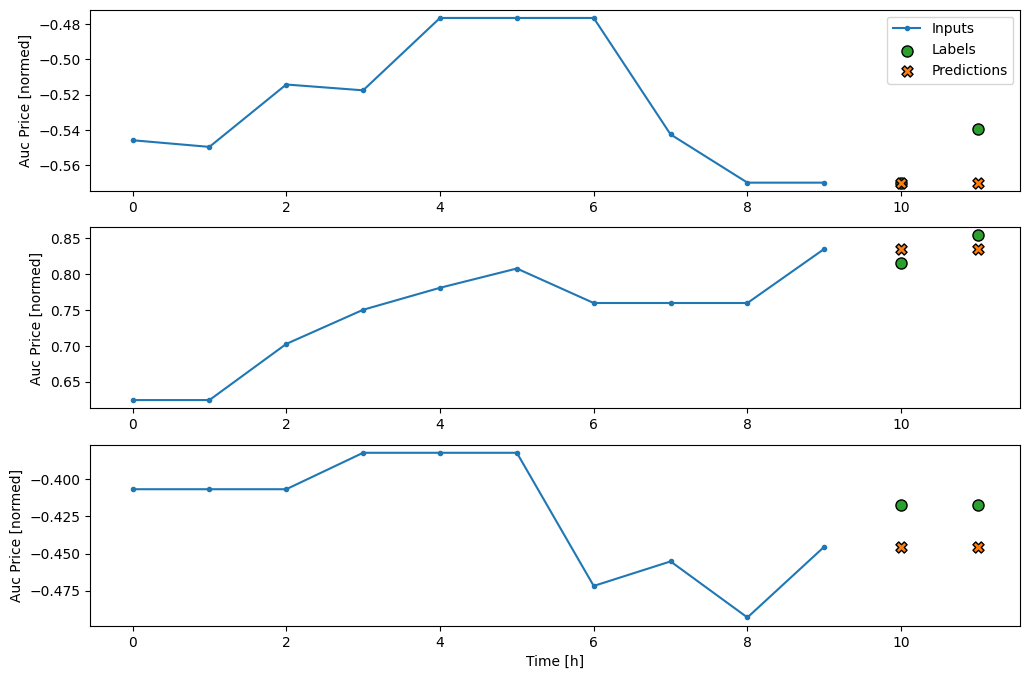

In [40]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

### Multi Linear Model

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 0.8173 - mean_absolute_error: 0.5627
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 0.8526 - mean_absolute_error: 0.6136


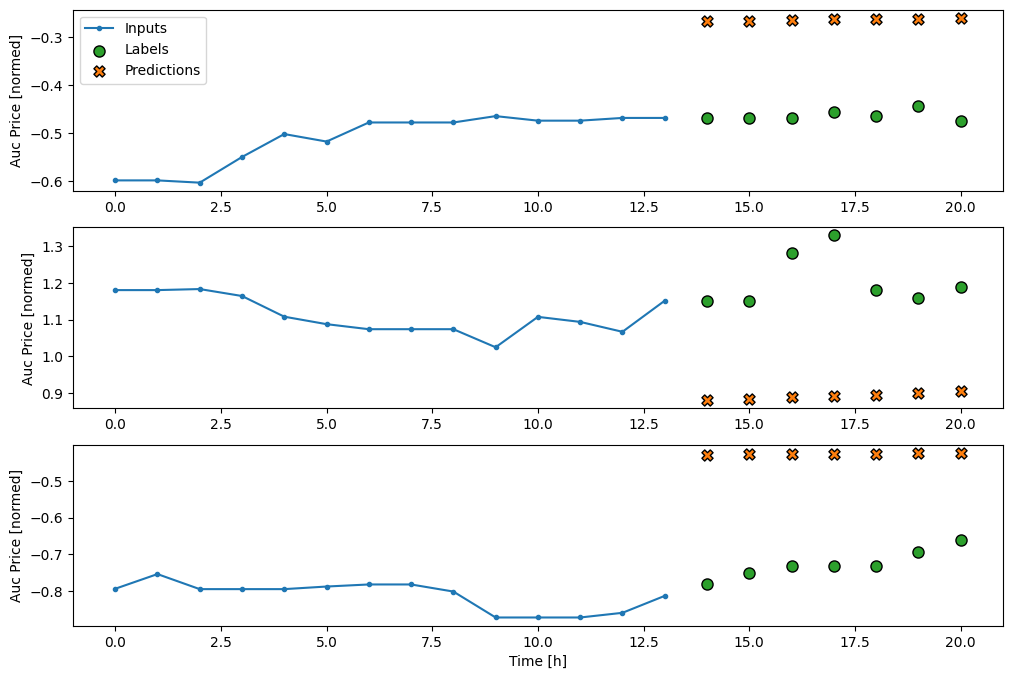

In [21]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=1, return_dict=True)
multi_window.plot(multi_linear_model)

### Dense Model

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 0.7051 - mean_absolute_error: 0.4764


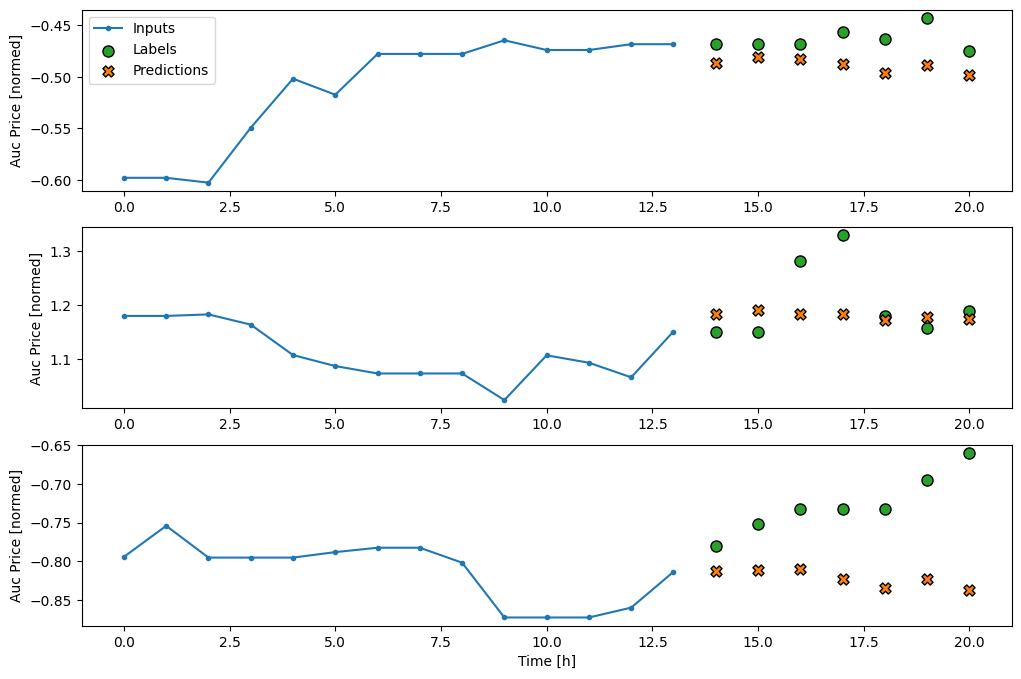

In [22]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

### Conv Model

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 0.7457 - mean_absolute_error: 0.5441


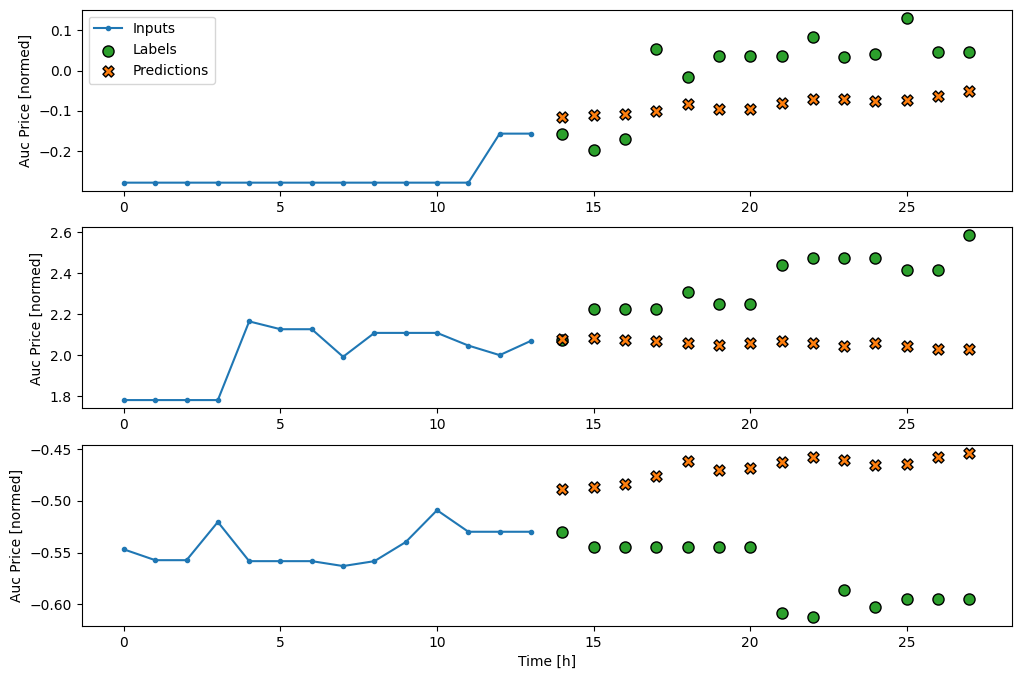

In [24]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=14,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

MAX_EPOCHS = 10
history = compile_and_fit(multi_conv_model, multi_window, MAX_EPOCHS=MAX_EPOCHS)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

### Multi-step LSTM Model

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.7617 - mean_absolute_error: 0.5185


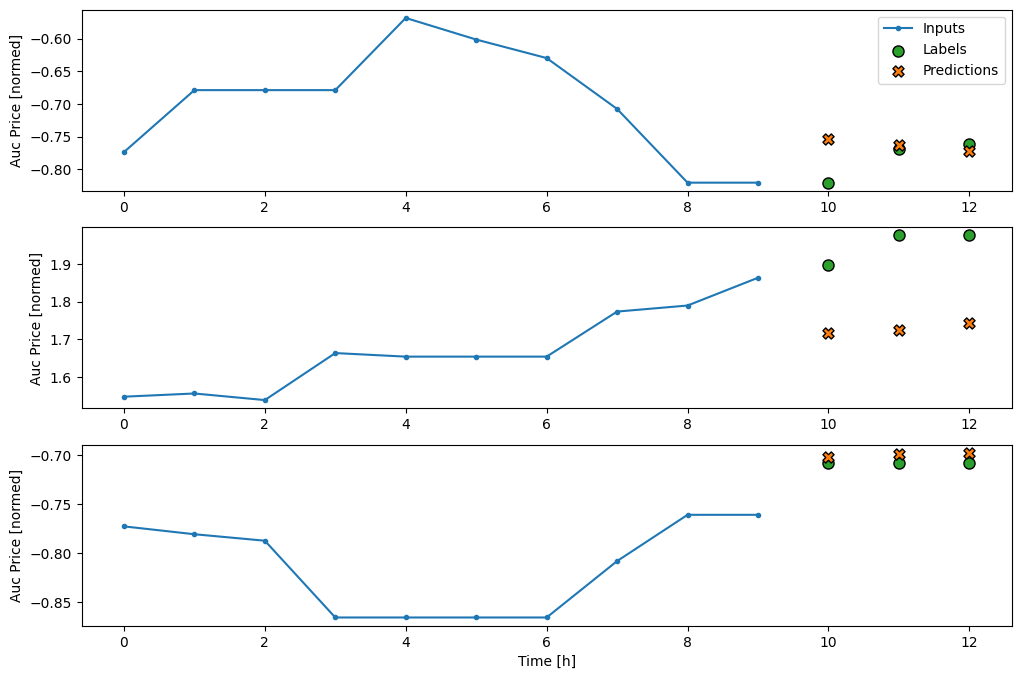

In [41]:
OUT_STEPS = 3
multi_window = WindowGenerator(input_width=10,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(50, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

### Feedback Model

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 0.7562 - mean_absolute_error: 0.5216


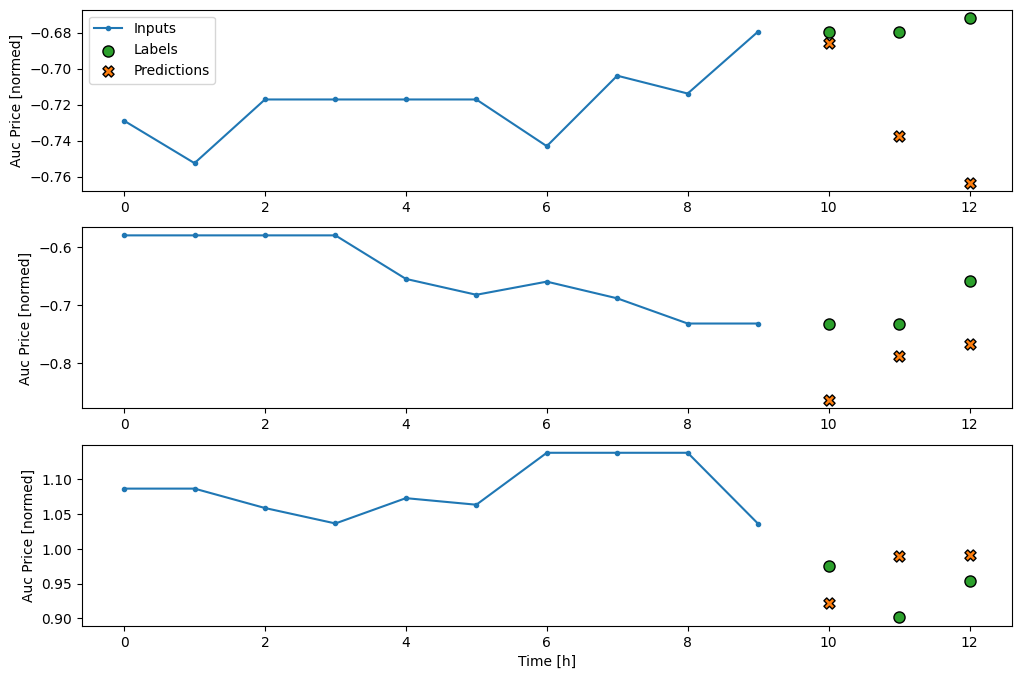

In [42]:
OUT_STEPS = 3
multi_window = WindowGenerator(input_width=10,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)


class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)
    
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state


def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
FeedBack.call = call
FeedBack.warmup = warmup

prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)


history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

### Advanced AR LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1321 - mean_absolute_error: 0.6978


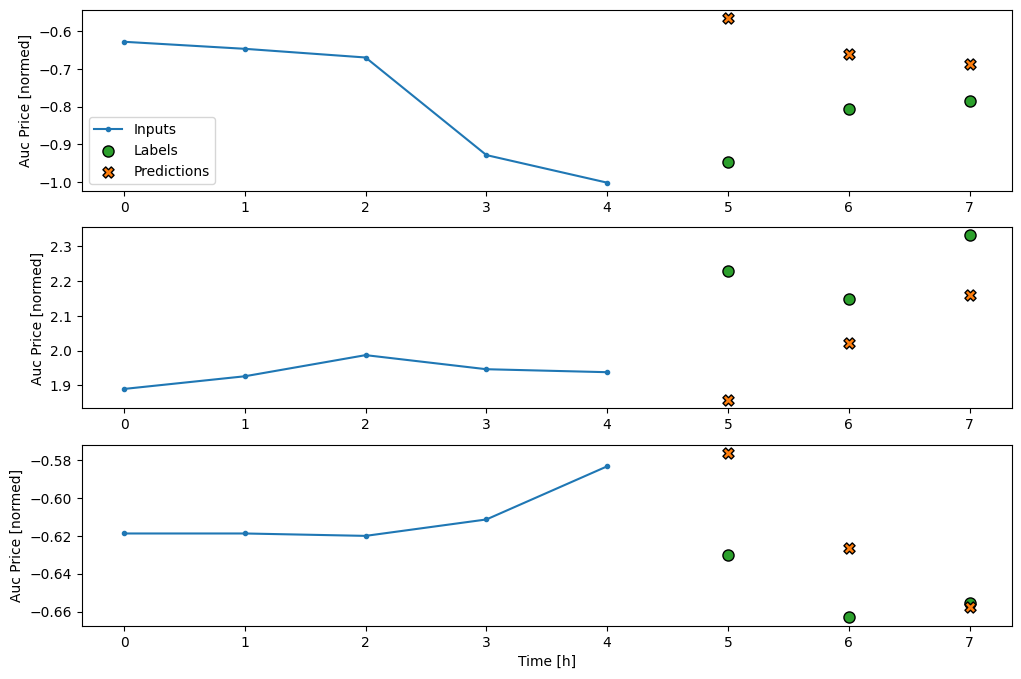

In [270]:
merged_df = merge_auc_cot(auction_df, cot_df)
train_df, test_df, val_df = train_test_data(merged_df)
train_df, test_df, val_df = normalize(train_df, test_df, val_df)
num_features = train_df.shape[1]    

OUT_STEPS = 3
INPUT_STEPS = 5
multi_window = WindowGenerator(input_width=INPUT_STEPS,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

class AdvancedFeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        
        # Bidirectional LSTM layer
        self.bidirectional_lstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(units, return_sequences=True))
        
        # Attention mechanism
        self.attention = tf.keras.layers.Attention()
        
        # Dense layers with dropout and residual connections
        self.dense1 = tf.keras.layers.Dense(units, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            x = self.bidirectional_lstm(x)
            
            # Attention mechanism
            context_vector, attention_weights = self.attention([x, x], return_attention_scores=True)
            x = context_vector
            
            # Dense layers with residual connection
            x = self.dense1(x)
            x = self.dropout(x, training=training)
            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

advanced_feedback_model = AdvancedFeedBack(units=64, out_steps=OUT_STEPS, num_features=num_features)
AdvancedFeedBack.call = call
AdvancedFeedBack.warmup = warmup

prediction, state = advanced_feedback_model.warmup(multi_window.example[0])
print('Output shape (batch, time, features): ', advanced_feedback_model(multi_window.example[0]).shape)

history = compile_and_fit(advanced_feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Advanced AR LSTM'] = advanced_feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Advanced AR LSTM'] = advanced_feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(advanced_feedback_model)

In [263]:
test_df = merged_df[merged_df['Date'].dt.year >= 2023].set_index('Date')

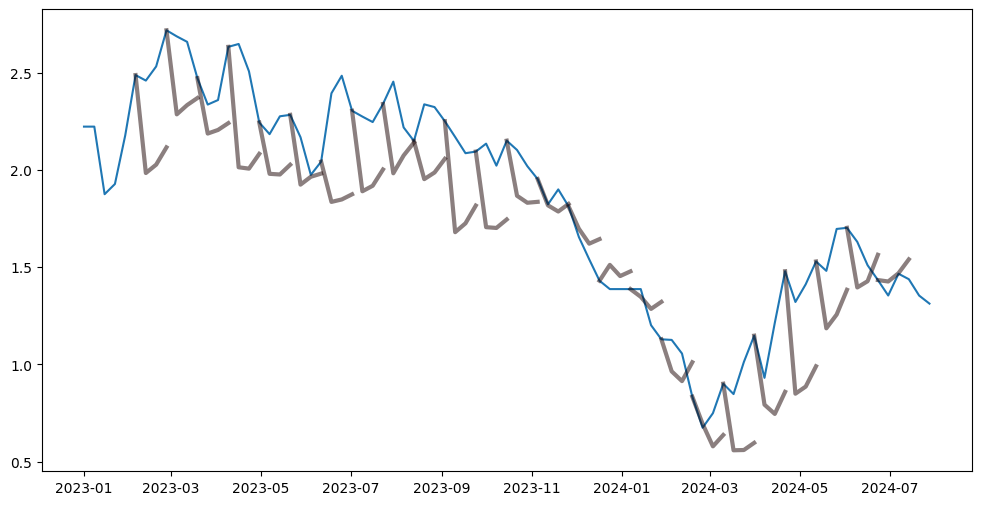

In [271]:
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df['Auc Price'])
for i in range(0, test_df.shape[0], 3):
    if i < INPUT_STEPS or i > test_df.shape[0]-INPUT_STEPS: continue
    inputs = test_df[i-INPUT_STEPS: i].copy()
    outputs = test_df[i-1: i+OUT_STEPS].copy()
    colors = plt.cm.hot(np.linspace(0, 1, 100))
    
    data = np.array(inputs, dtype=np.float32)
    predictions = advanced_feedback_model(data.reshape(1, INPUT_STEPS, test_df.shape[1]))
    for i in range(OUT_STEPS):
        outputs.iloc[i+1, :] = np.array(predictions[0][i])
    plt.plot(outputs.index, outputs['Auc Price'], color=colors[i], alpha=0.5, linewidth=3)
    # break

plt.show()

### Advanced AR LSTM with Multi-Head Attention

In [258]:
merged_df

,Date,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short,Pct_Change_Auc_Price,delta_auc,delta_auc_4,auc_T-2,auc_T-4,delta_ls,delta_ls_4,ls_T-2,ls_T-4
5,2018-07-15,16.005000,3.040000,-0.0750,-0.1025,-0.004669,51059.21,5.50,0.69,7.971014,4.744764,1.015000,0.795000,14.9900,15.2100,-0.305909,-7.195652,14.9900,15.2100
6,2018-07-22,16.308000,3.222000,-0.0460,-0.0800,-0.002815,54874.03,5.74,0.60,9.566667,1.893158,1.028000,1.852000,15.2800,14.4560,0.905376,-0.760256,15.2800,14.4560
7,2018-07-29,17.137500,3.042500,-0.0425,-0.1075,-0.002470,54438.12,5.57,0.55,10.127273,5.086461,1.132500,2.147500,16.0050,14.9900,2.156258,1.850350,16.0050,14.9900
8,2018-08-05,17.270000,4.386000,0.0160,-0.0640,0.000931,57345.88,5.91,0.63,9.380952,0.773158,0.962000,1.990000,16.3080,15.2800,-0.185714,0.719662,16.3080,15.2800
9,2018-08-12,17.570000,4.925000,0.0425,-0.0500,0.002429,59152.83,6.02,0.63,9.555556,1.737116,0.432500,1.565000,17.1375,16.0050,-0.571717,1.584541,17.1375,16.0050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2024-06-30,65.795000,1.537500,-0.1200,-0.2550,-0.001822,-21215.03,5.13,8.23,0.623329,-2.482585,-3.282500,-7.335000,69.0775,73.1300,-0.115323,-0.229456,69.0775,73.1300
317,2024-07-07,68.154000,1.498000,-0.2080,-0.2160,-0.003043,-17487.03,5.22,7.67,0.680574,3.585379,0.684000,-3.456000,67.4700,71.6100,0.037613,-0.135891,67.4700,71.6100
318,2024-07-14,67.562000,1.654000,-0.2200,-0.2400,-0.003254,-18113.99,5.00,7.48,0.668449,-0.868621,1.767000,-1.515500,65.7950,69.0775,0.045120,-0.070203,65.7950,69.0775
319,2024-07-21,65.788000,1.744000,0.0700,-0.1440,0.001050,-23378.80,5.18,8.33,0.621849,-2.625736,-2.366000,-1.682000,68.1540,67.4700,-0.058725,-0.021112,68.1540,67.4700


In [238]:
train_df.columns

['Auc Price', 'Cover Ratio',
       'Premium/discount-settle', 'net_speculators', 'spec_long_%',
       'spec_short_%', 'Long/Short', 'Pct_Change_Auc_Price', 'delta_auc',
       'delta_auc_4', 'auc_T-2', 'auc_T-4', 'delta_ls', 'delta_ls_4', 'ls_T-2',
       'ls_T-4']

['Auc Price',
 'Cover Ratio',
 'Premium/discount-settle',
 'net_speculators',
 'spec_long_%',
 'spec_short_%',
 'Long/Short',
 'Pct_Change_Auc_Price',
 'delta_auc',
 'delta_auc_4',
 'auc_T-2',
 'auc_T-4',
 'delta_ls',
 'delta_ls_4',
 'ls_T-2',
 'ls_T-4']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2287 - mean_absolute_error: 0.7592


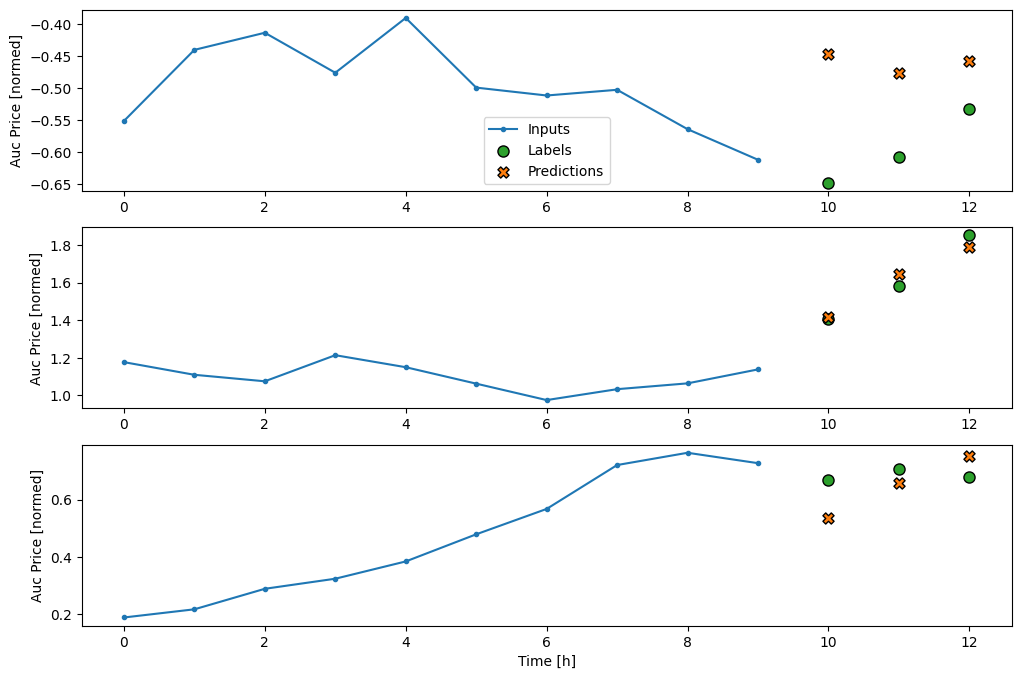

In [272]:
# merged_df = merge_auc_cot(auction_df, cot_df)
# features = ['Auc Price', 'Cover Ratio',
#        'Premium/discount-settle', 'net_speculators', 'spec_long_%',
#        'spec_short_%', 'Long/Short', 'Pct_Change_Auc_Price', 'delta_auc',
#        'delta_auc_4', 'auc_T-2', 'auc_T-4', 'delta_ls', 'delta_ls_4', 'ls_T-2',
#        'ls_T-4']

# train_df, test_df, val_df = train_test_data(merged_df, features=features)
# train_df, test_df, val_df = normalize(train_df, test_df, val_df)
# num_features = train_df.shape[1]    

# OUT_STEPS = 3
# multi_window = WindowGenerator(input_width=10,
#                                train_df=train_df, val_df=val_df, test_df=test_df,
#                                label_width=OUT_STEPS,
#                                shift=OUT_STEPS)


merged_df = merge_auc_cot(auction_df, cot_df)
train_df, test_df, val_df = train_test_data(merged_df)
train_df, test_df, val_df = normalize(train_df, test_df, val_df)
num_features = train_df.shape[1]    

OUT_STEPS = 3
INPUT_STEPS = 10
multi_window = WindowGenerator(input_width=INPUT_STEPS,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)



class AdvancedFeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features, num_heads=4):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        
        # Bidirectional LSTM layer
        self.bidirectional_lstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(units, return_sequences=True))
        
        # Multi-head attention mechanism
        # self.multi_head_attention = tf.keras.layers.MultiHeadAttention(
        #     num_heads=num_heads, key_dim=units)
        
        # Dense layers with dropout and residual connections
        self.dense1 = tf.keras.layers.Dense(units, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            x = self.bidirectional_lstm(x)
            
            # Multi-head attention mechanism
            x = self.multi_head_attention(query=x, value=x)
            
            # Dense layers with residual connection
            x = self.dense1(x)
            x = self.dropout(x, training=training)
            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

advanced_feedback_model = AdvancedFeedBack(units=64, out_steps=OUT_STEPS, num_features=num_features, num_heads=4)
AdvancedFeedBack.call = call
AdvancedFeedBack.warmup = warmup

prediction, state = advanced_feedback_model.warmup(multi_window.example[0])
print('Output shape (batch, time, features): ', advanced_feedback_model(multi_window.example[0]).shape)

history = compile_and_fit(advanced_feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Advanced AR LSTM with Multi-Head Attention'] = advanced_feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Advanced AR LSTM with Multi-Head Attention'] = advanced_feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(advanced_feedback_model)

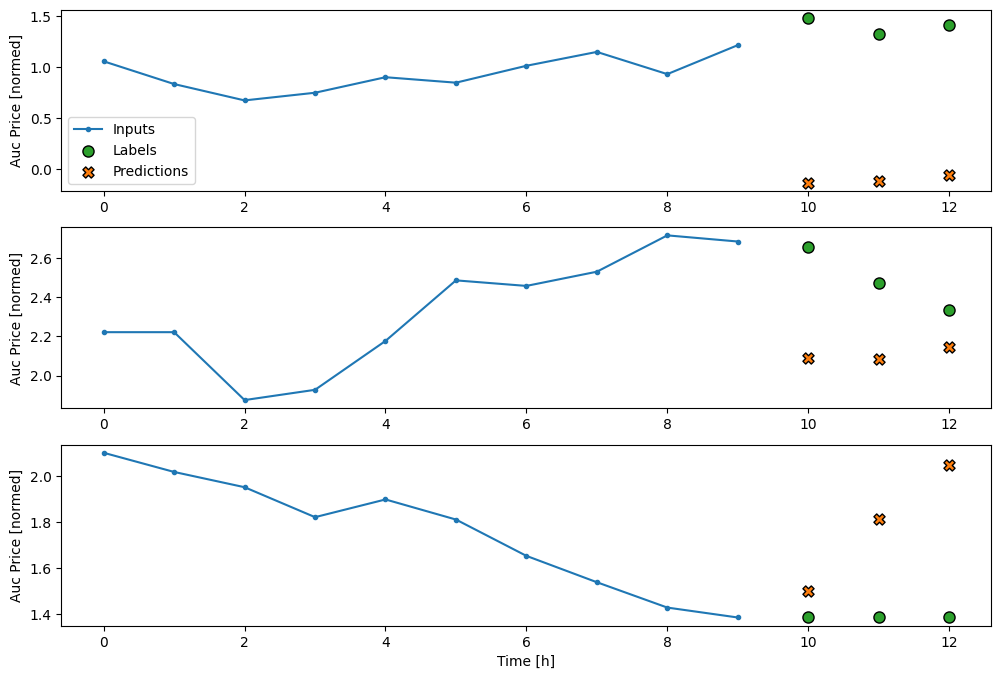

In [273]:
multi_window.plot_test(advanced_feedback_model)

In [245]:
test_df.shape

(53, 16)

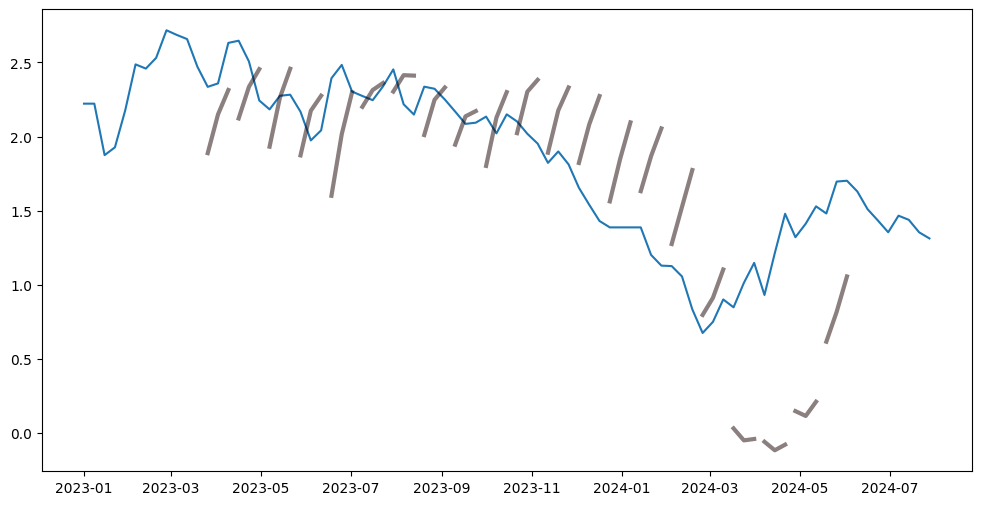

In [275]:
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df['Auc Price'])
for i in range(0, test_df.shape[0], 3):
    if i < INPUT_STEPS or i > test_df.shape[0]-INPUT_STEPS: continue
    inputs = test_df[i-INPUT_STEPS: i].copy()
    outputs = test_df[i: i+OUT_STEPS].copy()
    colors = plt.cm.hot(np.linspace(0, 1, 100))
    
    data = np.array(inputs, dtype=np.float32)
    predictions = advanced_feedback_model(data.reshape(1, INPUT_STEPS, test_df.shape[1]))
    for i in range(OUT_STEPS):
        outputs.iloc[i, :] = np.array(predictions[0][i])
    plt.plot(outputs.index, outputs['Auc Price'], color=colors[i], alpha=0.5, linewidth=3)
    # break

plt.show()

In [174]:
data.shape

(10, 18)

In [134]:
outputs.iloc[0, :]

Auc Price                  1.968244
Cover Ratio               -0.015288
Auction Spot Diff         -2.137422
Median Spot Diff          -0.153480
Premium/discount-settle   -0.916012
net_speculators           -2.178878
spec_long_%               -1.854265
spec_short_%               0.672459
Long/Short                -1.329439
Pct_Change_Auc_Price      -0.057815
delta_auc                  2.045604
T-2                        2.247055
delta_auc_4               -2.620190
auc_T-2                    1.819950
auc_T-4                    2.247055
delta_ls                   0.050947
delta_ls_4                -1.198075
ls_T-2                     1.819950
ls_T-4                     2.247055
Name: 2023-01-11 00:00:00, dtype: float64

In [111]:
inputs

,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short,Pct_Change_Auc_Price,delta_auc,T-2,delta_auc_4,auc_T-2,auc_T-4,delta_ls,delta_ls_4,ls_T-2,ls_T-4
Date,,,,,,,,,,,,,,,,,,,
2023-01-01,2.227301,-1.148272,-5.449081,-0.118451,-2.384110,-1.714920,-1.454391,0.131516,-1.053712,-0.057815,-0.058737,2.247055,-0.084021,2.237738,2.247055,-1.306120,-0.888805,2.237738,2.247055
2023-01-02,2.227301,-1.148272,-5.449081,-0.118451,-2.384110,-1.714920,-1.454391,0.131516,-1.053712,-0.057815,-0.058737,2.247055,-0.084021,2.237738,2.247055,-1.306120,-0.888805,2.237738,2.247055
2023-01-03,2.227301,-1.148272,-5.449081,-0.118451,-2.384110,-1.714920,-1.454391,0.131516,-1.053712,-0.057815,-0.058737,2.247055,-0.084021,2.237738,2.247055,0.050947,-0.888805,2.237738,2.247055
2023-01-04,2.227301,-1.148272,-5.449081,-0.118451,-2.384110,-1.714920,-1.454391,0.131516,-1.053712,-0.057815,-0.058737,2.247055,-0.084021,2.237738,2.247055,0.050947,-0.888805,2.237738,2.247055
2023-01-05,2.227301,-1.148272,-5.449081,-0.118451,-2.384110,-1.714920,-1.454391,0.131516,-1.053712,-0.057815,-0.058737,2.247055,-0.084021,2.237738,2.247055,0.050947,0.072036,2.237738,2.247055
2023-01-06,2.227301,-1.148272,-5.449081,-0.118451,-2.384110,-1.714920,-1.454391,0.131516,-1.053712,-0.057815,-0.058737,2.247055,-0.084021,2.237738,2.247055,0.050947,0.072036,2.237738,2.247055
2023-01-07,2.227301,-1.148272,-5.449081,-0.118451,-2.384110,-1.714920,-1.454391,0.131516,-1.053712,-0.057815,-0.058737,2.247055,-0.084021,2.237738,2.247055,0.050947,0.072036,2.237738,2.247055
2023-01-08,2.227301,-1.148272,-5.449081,-0.118451,-2.384110,-2.178878,-1.854265,0.672459,-1.329439,-0.057815,-0.058737,2.247055,-0.084021,2.237738,2.247055,-1.742925,-1.198075,2.237738,2.247055
2023-01-09,1.810639,0.495353,0.919494,-0.108599,0.649420,-2.178878,-1.854265,0.672459,-1.329439,-4.161287,-5.622011,2.247055,-4.163142,2.237738,2.247055,-1.742925,-1.198075,2.237738,2.247055


In [90]:
# advanced_feedback_model(inputs.__array__())

In [91]:
data = np.array(inputs, dtype=np.float32)


In [97]:
predictions = advanced_feedback_model(data.reshape(1, 10, 19))

In [110]:
predictions[0][0]

<tf.Tensor: shape=(19,), dtype=float32, numpy=
array([ 1.7220017 , -0.3140079 , -1.1004313 ,  0.6985892 , -0.4562042 ,
       -1.6259713 , -1.1629868 ,  0.4084766 , -1.1907308 , -0.10329683,
       -0.6462431 ,  1.8948033 , -2.2012846 ,  2.1252985 ,  2.2886987 ,
        0.46478114, -0.24021116,  2.132396  ,  2.2499473 ], dtype=float32)>

In [109]:
predictions[0][2]

<tf.Tensor: shape=(19,), dtype=float32, numpy=
array([ 1.8988044 , -0.24671154, -0.8628862 ,  0.87268066, -0.23376074,
       -1.7006739 , -1.2769524 ,  0.42600754, -1.0600287 ,  0.07652203,
       -0.15955831,  2.0179255 , -0.8982207 ,  2.162851  ,  2.5000596 ,
        0.38433084,  0.13232814,  2.1381512 ,  2.3963873 ], dtype=float32)>

In [107]:
test_df

,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short,Pct_Change_Auc_Price,delta_auc,T-2,delta_auc_4,auc_T-2,auc_T-4,delta_ls,delta_ls_4,ls_T-2,ls_T-4
Date,,,,,,,,,,,,,,,,,,,
2023-01-01,2.227301,-1.148272,-5.449081,-0.118451,-2.384110,-1.714920,-1.454391,0.131516,-1.053712,-0.057815,-0.058737,2.247055,-0.084021,2.237738,2.247055,-1.306120,-0.888805,2.237738,2.247055
2023-01-02,2.227301,-1.148272,-5.449081,-0.118451,-2.384110,-1.714920,-1.454391,0.131516,-1.053712,-0.057815,-0.058737,2.247055,-0.084021,2.237738,2.247055,-1.306120,-0.888805,2.237738,2.247055
2023-01-03,2.227301,-1.148272,-5.449081,-0.118451,-2.384110,-1.714920,-1.454391,0.131516,-1.053712,-0.057815,-0.058737,2.247055,-0.084021,2.237738,2.247055,0.050947,-0.888805,2.237738,2.247055
2023-01-04,2.227301,-1.148272,-5.449081,-0.118451,-2.384110,-1.714920,-1.454391,0.131516,-1.053712,-0.057815,-0.058737,2.247055,-0.084021,2.237738,2.247055,0.050947,-0.888805,2.237738,2.247055
2023-01-05,2.227301,-1.148272,-5.449081,-0.118451,-2.384110,-1.714920,-1.454391,0.131516,-1.053712,-0.057815,-0.058737,2.247055,-0.084021,2.237738,2.247055,0.050947,0.072036,2.237738,2.247055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,1.396337,-0.781249,-0.914655,-0.153480,-0.411116,-3.008030,-0.442710,6.108602,-1.454676,-0.057815,-0.058737,1.411940,-0.084021,1.404527,1.411940,0.050947,0.097637,1.404527,1.411940
2023-12-28,1.396337,-0.781249,-0.914655,-0.153480,-0.411116,-3.008030,-0.442710,6.108602,-1.454676,-0.057815,-0.058737,1.411940,-0.084021,1.404527,1.411940,0.050947,0.072036,1.404527,1.411940
2023-12-29,1.396337,-0.781249,-0.914655,-0.153480,-0.411116,-3.008030,-0.442710,6.108602,-1.454676,-0.057815,-0.058737,1.411940,-0.084021,1.404527,1.411940,0.050947,0.072036,1.404527,1.411940


In [48]:
predictions = model(inputs)
plt.scatter(self.label_indices, predictions[n, :, label_col_index],
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)

,Date,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short,Pct_Change_Auc_Price,delta_auc,T-2,delta_auc_4,auc_T-2,auc_T-4,delta_ls,delta_ls_4,ls_T-2,ls_T-4
5,2018-06-09,15.78,1.77,-0.09,-0.07,0.000637,50668.63,5.40,0.39,13.846154,0.000000,-0.36,16.35,-0.57,16.14,16.35,0.0000,0.0000,16.14,16.35
6,2018-06-10,15.78,1.77,-0.09,-0.07,0.000637,50838.47,5.40,0.39,13.846154,0.000000,0.00,15.70,0.08,15.78,15.70,0.0000,0.0000,15.78,15.70
7,2018-06-11,15.70,2.03,0.01,-0.10,0.000637,50838.47,5.40,0.39,13.846154,-0.506971,-0.08,16.14,-0.44,15.78,16.14,0.0000,0.0000,15.78,16.14
8,2018-06-12,15.08,1.63,-0.12,-0.07,-0.007895,50838.47,5.40,0.39,13.846154,-3.949045,-0.70,15.78,-0.70,15.78,15.78,0.0000,0.0000,15.78,15.78
9,2018-06-13,15.08,1.63,-0.12,-0.07,-0.007895,50838.47,5.40,0.39,13.846154,0.000000,-0.62,15.78,-0.70,15.70,15.78,0.0000,0.0000,15.70,15.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,2024-07-21,64.73,2.24,0.01,-0.24,0.000155,-23378.80,5.18,8.33,0.621849,0.000000,0.00,66.66,-1.93,64.73,66.66,-0.0466,-0.0466,64.73,66.66
2240,2024-07-22,64.37,1.68,0.12,-0.23,0.001868,-23378.80,5.18,8.33,0.621849,-0.556156,-0.36,64.96,-0.59,64.73,64.96,-0.0466,-0.0466,64.73,64.96
2241,2024-07-23,63.67,1.60,-0.05,-0.18,-0.000785,-23378.80,5.18,8.33,0.621849,-1.087463,-1.06,64.73,-1.06,64.73,64.73,0.0000,-0.0466,64.73,64.73
2242,2024-07-24,63.67,1.60,-0.05,-0.18,-0.000785,-23378.80,5.18,8.33,0.621849,0.000000,-0.70,64.73,-1.06,64.37,64.73,0.0000,-0.0466,64.37,64.73


In [72]:
t = multi_window.make_dataset(inputs)

In [87]:
t = multi_window.test_example

In [88]:
t

(<tf.Tensor: shape=(32, 10, 19), dtype=float32, numpy=
 array([[[ 2.4972105e+00,  1.9216025e-01,  3.1102841e+00, ...,
           4.1449958e-01,  2.4511275e+00,  2.4044991e+00],
         [ 2.7001147e+00,  1.2833014e-01,  2.6517467e+00, ...,
           4.1449958e-01,  2.4511275e+00,  2.4609323e+00],
         [ 2.7001147e+00,  1.2833014e-01,  2.6517467e+00, ...,
           4.1449958e-01,  2.5083783e+00,  2.4609323e+00],
         ...,
         [ 2.7086084e+00,  4.1556561e-01,  2.9064898e+00, ...,
           6.3183594e-01,  2.7203481e+00,  2.7307680e+00],
         [ 2.7661765e+00,  1.4428768e-01,  2.3460553e+00, ...,
           6.3183594e-01,  2.7203481e+00,  2.7307680e+00],
         [ 2.6897335e+00, -3.6635318e-01, -1.4750900e+00, ...,
           6.3183594e-01,  2.7203481e+00,  2.7307680e+00]],
 
        [[ 2.2933626e+00,  1.9474882e+00,  5.2501254e+00, ...,
           7.2035879e-02,  2.4156415e+00,  2.3371587e+00],
         [ 2.2933626e+00,  1.9474882e+00,  5.2501254e+00, ...,
           

In [71]:
t = advanced_feedback_model(inputs)

2024-08-23 23:54:49.814174: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: Index out of range using input dim 2; input has only 2 dims


InvalidArgumentError: Exception encountered when calling RNN.call().

[1m{{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: advanced_feed_back_2/rnn_4/strided_slice/[0m

Arguments received by RNN.call():
  • sequences=tf.Tensor(shape=(10, 19), dtype=float32)
  • initial_state=None
  • mask=None
  • training=False

In [54]:
# Define the target variable
target_col = 'Pct_Change_Auc_Price(t)'

# Extract features and target
features = lagged_data.drop(columns=[target_col])
target = lagged_data[target_col]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=False)

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Original X_train_scaled shape: {X_train_scaled.shape}")
print(f"Original X_test_scaled shape: {X_test_scaled.shape}")

Original X_train_scaled shape: (1792, 32)
Original X_test_scaled shape: (449, 32)


In [55]:
# Number of timesteps (lags)
n_timesteps = 2

# Calculate number of features
n_features = X_train_scaled.shape[1] // n_timesteps

# Reshape the data
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], n_timesteps, n_features))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], n_timesteps, n_features))

print(f"Reshaped X_train_scaled shape: {X_train_scaled.shape}")
print(f"Reshaped X_test_scaled shape: {X_test_scaled.shape}")

Reshaped X_train_scaled shape: (1792, 2, 16)
Reshaped X_test_scaled shape: (449, 2, 16)


In [56]:
# Convert target to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=2, shuffle=False)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test MAE: {test_mae}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


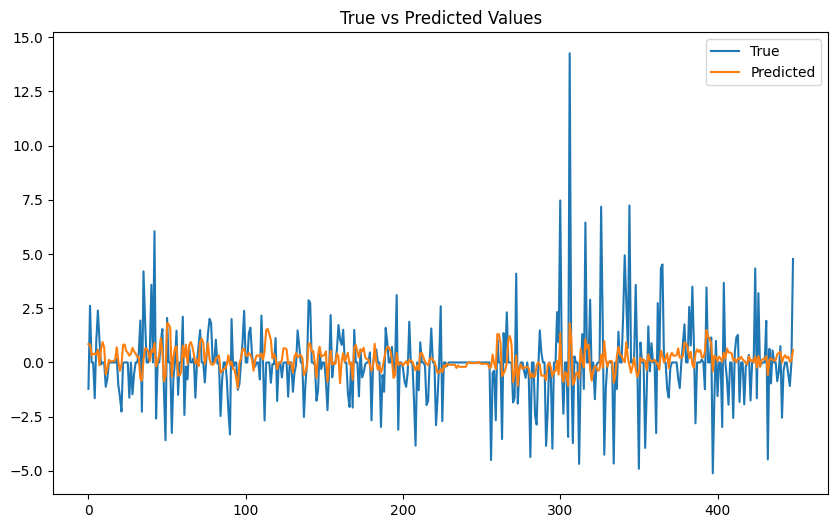

In [58]:
# Make predictions
y_pred = model.predict(X_test_scaled)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [64]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1))) 
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1))) 
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

ValueError: The layer sequential_2 has never been called and thus has no defined output.